# BLoc 0: Offline (FakeGen/FakeScope)

In [50]:
# ============================================
# BLOC 0 — MODE OFFLINE (FAKE GEN + FAKE SCOPE)
# ============================================
# Objectif:
# - Valider tout ton code chez toi SANS instruments VISA
# - Simuler un LM741 en:
#   - Gain BF (OFFLINE_GAIN)
#   - Coupure -3dB (OFFLINE_FC_HZ) via un 1er ordre
#   - Slew-rate (OFFLINE_SR_VUS) sur signaux à fronts (carré/tri)
#
# IMPORTANT:
# - Le FakeScope renvoie un waveform comme un Rigol: :WAV:PRE? + :WAV:DATA?
# - :WAV:DATA? renvoie un "SCPI binary block" : b"#<d><len><bytes>"
# - read_waveform() reconstruit t (s) et v (V) proprement
# ============================================

import numpy as np

OFFLINE = True  # False au labo
rm = None       # évite "rm not defined" en offline

# =========================
# PARAMS OFFLINE (tu changes ICI)
# =========================
OFFLINE_GAIN   = 2.0         # gain BF (ex: non-inverseur = 2)
OFFLINE_FC_HZ  = 50_000.0    # fréquence de coupure (-3 dB) simulée
OFFLINE_SR_VUS = 0.50        # slew rate simulé (V/us) ~ LM741 typique


# =========================
# PARAMS OUTPUT SWING (OFFLINE)
# =========================
OFFLINE_VOUT_MAX = 10.0   # V  (ex: ±10 V pour alim ±15 V)
OFFLINE_VOUT_MIN = -10.0


# =========================
# Fake Generator
# =========================
class FakeGen:
    """
    Simule un générateur.
    On mémorise uniquement CH1: wave, freq, vpp, offset, phase, ON/OFF.
    """
    def __init__(self, name="GEN"):
        self.name = name
        self.timeout = 10000
        self.read_termination = "\n"
        self.write_termination = "\n"
        self.chunk_size = 102400

        self.ch1_on = False
        self.wave = "SIN"      # SIN / SQU / RAMP / TRI
        self.freq_hz = 1000.0
        self.vpp = 1.0
        self.offset = 0.0
        self.phase = 0.0

    def clear(self): pass
    def close(self): pass

    def write(self, cmd: str):
        print(f"[{self.name} WRITE] {cmd}")
        c = cmd.strip().upper()

        # ON/OFF
        if c in ("OUTP ON", "OUT ON", "OUTP1 ON"):
            self.ch1_on = True
            return
        if c in ("OUTP OFF", "OUT OFF", "OUTP1 OFF"):
            self.ch1_on = False
            return

        # Phase
        if c.startswith("PHAS "):
            try:
                self.phase = float(c.split()[1])
            except:
                pass
            return

        # APPL:<WAVE> f,vpp,offs
        # ex: APPL:SIN 1000,1.0,0.0
        if c.startswith("APPL:"):
            try:
                left, right = c.split(" ", 1)
                self.wave = left.split(":")[1]  # SIN/SQU/RAMP/TRI
                parts = [p.strip() for p in right.split(",")]
                self.freq_hz = float(parts[0])
                self.vpp = float(parts[1])
                self.offset = float(parts[2]) if len(parts) > 2 else 0.0
            except:
                pass
            return

        # VOLT:UNIT VPP etc -> ignoré en offline (mais on affiche)
        # rien d'autre requis

    def query(self, cmd: str):
        print(f"[{self.name} QUERY] {cmd}")
        c = cmd.strip().upper()
        if c in ("OUTP?", "OUT?", "OUTP1?"):
            return "ON" if self.ch1_on else "OFF"
        if "FREQ" in c:
            return str(self.freq_hz)
        if "VPP" in c:
            return str(self.vpp)
        return "0"


# =========================
# Fake Scope
# =========================
class FakeScope:
    """
    Simule un oscilloscope style Rigol:
    - :WAV:PRE? renvoie un preamble (xincr, yincr, etc.)
    - :WAV:DATA? renvoie un SCPI binary block (#<d><len>...)
    - CHAN1 = Vin (générateur)
    - CHAN2 = Vout = Vin * |H(f)| + limitation slew-rate si fronts
    """
    def __init__(self, gen: FakeGen, name="SCOPE"):
        self.name = name
        self.gen = gen

        self.timeout = 10000
        self.read_termination = "\n"
        self.write_termination = "\n"
        self.chunk_size = 102400

        self.wav_source = "CHAN1"

        # Preamble (valeurs typiques)
        self.N = 4000
        self.xincr = 1e-7
        self.xorig = 0.0
        self.xref  = 0.0
        self.yincr = 0.02
        self.yorig = 0.0
        self.yref  = 127.0

    def clear(self): pass
    def close(self): pass

    def write(self, cmd: str):
        print(f"[{self.name} WRITE] {cmd}")
        c = cmd.strip().upper()
        if c.startswith(":WAV:SOUR"):
            # ex : :WAV:SOUR CHAN1
            self.wav_source = c.split()[-1]

        # Dans ce fake, on ignore volontairement:
        # :WAV:FORM, :WAV:MODE, :TIM:SCAL, :TRIG..., :RUN, etc.

    def query(self, cmd: str):
        print(f"[{self.name} QUERY] {cmd}")
        c = cmd.strip().upper()

        # PREAMBLE
        if "WAV:PRE?" in c:
            # FORMAT,TYPE,POINTS,COUNT,XINCR,XORIG,XREF,YINCR,YORIG,YREF
            return f"0,0,{self.N},1,{self.xincr},{self.xorig},{self.xref},{self.yincr},{self.yorig},{self.yref}"

        # DATA (bloc binaire)
        if "WAV:DATA?" in c:
            return self.read_raw()

        # MEAS:ITEM? (optionnel) pour simuler des lectures rapides
        if ":MEAS:ITEM?" in c:
            if "FREQ" in c:
                return str(self.gen.freq_hz)
            if "VPP" in c:
                vin = self.gen.vpp if self.gen.ch1_on else 0.0
                if "CHAN2" in c:
                    return str(self._vout_vpp(vin))
                return str(vin)
            if "VAVG" in c:
                return str(self.gen.offset)
            if "RTIM" in c:
                return "10e-6"  # 10 µs simulé
            return "0"

        return "0"

    def _vout_vpp(self, vin_vpp: float) -> float:
        """|H(f)| 1er ordre: G / sqrt(1+(f/fc)^2)"""
        f = max(1e-9, self.gen.freq_hz)
        G = OFFLINE_GAIN
        fc = OFFLINE_FC_HZ
        mag = G / np.sqrt(1.0 + (f / fc) ** 2)
        return vin_vpp * mag

    def read_raw(self) -> bytes:
        """
        Renvoie un bloc binaire SCPI:
        b"#<ndigits><len><data>"
        où data = N octets (0..255) correspondant au waveform.
        """
        t = np.arange(self.N) * self.xincr

        # -------- Vin ----------
        if not self.gen.ch1_on:
            vin = np.zeros_like(t)
        else:
            A = self.gen.vpp / 2.0
            f = self.gen.freq_hz
            w = self.gen.wave.upper()

            if w == "SIN":
                vin = A * np.sin(2*np.pi*f*t)
            elif w == "SQU":
                vin = A * np.sign(np.sin(2*np.pi*f*t))
            elif w in ("RAMP", "TRI"):
                vin = A * (2/np.pi) * np.arcsin(np.sin(2*np.pi*f*t))
            else:
                vin = A * np.sin(2*np.pi*f*t)

            vin = vin + self.gen.offset

        # -------- Vout ----------
        if self.wav_source == "CHAN1":
            v = vin
        else:
            vin_vpp = self.gen.vpp if self.gen.ch1_on else 0.0
            vout_vpp = self._vout_vpp(vin_vpp)
            Aout = vout_vpp / 2.0

            f = max(1e-9, self.gen.freq_hz)
            w = self.gen.wave.upper()

            if w == "SIN":
                v_ideal = Aout * np.sin(2*np.pi*f*t)
            elif w == "SQU":
                v_ideal = Aout * np.sign(np.sin(2*np.pi*f*t))
            elif w in ("RAMP", "TRI"):
                v_ideal = Aout * (2/np.pi) * np.arcsin(np.sin(2*np.pi*f*t))
            else:
                v_ideal = Aout * np.sin(2*np.pi*f*t)

            # Limite Slew Rate: |dv| <= SR*dt
            sr_vs = OFFLINE_SR_VUS * 1e6  # V/us -> V/s
            v = np.zeros_like(v_ideal)
            v[0] = v_ideal[0]
            for i in range(1, len(v)):
                dv = v_ideal[i] - v[i-1]
                dv_max = sr_vs * self.xincr
                dv = np.clip(dv, -dv_max, dv_max)
                v[i] = v[i-1] + dv

        # -------- Conversion V -> BYTE ----------
        y = np.round((v - self.yorig) / self.yincr + self.yref).astype(np.int32)
        y = np.clip(y, 0, 255).astype(np.uint8).tobytes()

        # Header SCPI binaire "#<d><len>"
        n = len(y)
        d = len(str(n))
        header = f"#{d}{n}".encode()
        return header + y


# =========================
# Helper: read_waveform()
# =========================
def read_waveform(scope, channel="CHAN1"):
    """
    Lecture style Rigol:
    - :WAV:SOUR CHANx
    - :WAV:PRE?
    - :WAV:DATA?
    Retour: t (s), v (V)
    """
    scope.write(f":WAV:SOUR {channel}")

    pre = scope.query(":WAV:PRE?")
    parts = [p.strip() for p in pre.split(",")]

    N     = int(parts[2])
    xincr = float(parts[4])
    xorig = float(parts[5])
    xref  = float(parts[6])
    yincr = float(parts[7])
    yorig = float(parts[8])
    yref  = float(parts[9])

    raw = scope.query(":WAV:DATA?")
    if isinstance(raw, str):
        raw = raw.encode()

    # Parse SCPI binary block
    if len(raw) < 3 or raw[0:1] != b"#":
        raise ValueError("Données waveform invalides (pas un SCPI binary block)")

    d = int(raw[1:2].decode())             # nombre de digits de la longueur
    n = int(raw[2:2+d].decode())           # longueur data
    data = raw[2+d:2+d+n]                  # bytes data

    y = np.frombuffer(data, dtype=np.uint8).astype(np.float64)

    # BYTE -> Volt
    v = (y - yref) * yincr + yorig

    # Temps
    i = np.arange(len(v), dtype=np.float64)
    t = (i - xref) * xincr + xorig

    # Trim si nécessaire
    if len(v) > N:
        v = v[:N]
        t = t[:N]

    return t, v


# =========================
# Factory OFFLINE
# =========================
if OFFLINE:
    gen = FakeGen("GEN")
    scope = FakeScope(gen, "SCOPE")

    # Mini test rapide pour prouver que tout marche
    gen.write("VOLT:UNIT VPP")
    gen.write("APPL:SIN 10000,1.0,0.0")
    gen.write("OUTP ON")

    t_in, v_in = read_waveform(scope, "CHAN1")
    t_out, v_out = read_waveform(scope, "CHAN2")

    print("OFFLINE OK:",
          "Vin Vpp≈", np.ptp(v_in),
          "| Vout Vpp≈", np.ptp(v_out),
          "| Gain≈", (np.ptp(v_out)/np.ptp(v_in) if np.ptp(v_in) > 1e-9 else 0))


[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 10000,1.0,0.0
[GEN WRITE] OUTP ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
OFFLINE OK: Vin Vpp≈ 1.0 | Vout Vpp≈ 1.96 | Gain≈ 1.96


# Bloc 1 : Détection IDs VISA (labo)

In [41]:
import pyvisa

rm = pyvisa.ResourceManager()
resources = rm.list_resources()

print("=== RESSOURCES VISA DETECTEES ===")
for i, r in enumerate(resources):
    print(f"[{i}] {r}")

print("\nNOTE:")
print("- USB0::... = instruments USBTMC (Rigol en USB normalement)")
print("- ASRLx::INSTR = ports série (COM). Ne choisis ça que si tu utilises un câble série/RS232.\n")

idx_gen = int(input("Index du GENERATEUR (ou -1 si pas présent): "))
idx_scope = int(input("Index de l'OSCILLO (ou -1 si pas présent): "))

GEN_ID = resources[idx_gen] if idx_gen >= 0 else None
SCOPE_ID = resources[idx_scope] if idx_scope >= 0 else None

# Avertissement si ASRL sélectionné
if GEN_ID and GEN_ID.startswith("ASRL"):
    print("\n⚠ ATTENTION: GEN_ID est un port série (ASRL).")
    print("   Si ton générateur est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...")

if SCOPE_ID and SCOPE_ID.startswith("ASRL"):
    print("\n⚠ ATTENTION: SCOPE_ID est un port série (ASRL).")
    print("   Si ton oscillo est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...")

print("\n=== IDS CHOISIS ===")
print("GEN_ID   =", GEN_ID)
print("SCOPE_ID =", SCOPE_ID)

rm.close()


=== RESSOURCES VISA DETECTEES ===
[0] ASRL7::INSTR
[1] ASRL8::INSTR

NOTE:
- USB0::... = instruments USBTMC (Rigol en USB normalement)
- ASRLx::INSTR = ports série (COM). Ne choisis ça que si tu utilises un câble série/RS232.


⚠ ATTENTION: GEN_ID est un port série (ASRL).
   Si ton générateur est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...

⚠ ATTENTION: SCOPE_ID est un port série (ASRL).
   Si ton oscillo est en USB, VISA ne le voit pas -> tu auras besoin de l'ID USB0::...

=== IDS CHOISIS ===
GEN_ID   = ASRL7::INSTR
SCOPE_ID = ASRL8::INSTR


# Bloc 2 : Prise en main générateur (écrire des commandes)

In [42]:
import time

# ============================================================
# BLOC 2 — Prise en main du GENERATEUR (Rigol DG1000)
# ============================================================
# - Ce bloc suppose que tu as déjà:
#   - OFFLINE défini UNE SEULE FOIS dans le main (ex: OFFLINE=True/False)
#   - GEN_ID défini (collé depuis le bloc 1)
#
# Objectif examen:
# - savoir générer SIN / SQU / RAMP avec freq, Vpp, offset, phase
# - ON/OFF canal
# - options: sweep, burst
# ============================================================

# ------------------------------------------------------------
# IMPORTANT: Ne redéfinis pas OFFLINE ici si tu as déjà un OFFLINE global.
# Si tu veux garder ce fichier autonome, alors décommente la ligne suivante:
# OFFLINE = True
# ------------------------------------------------------------

GEN_ID = "USB0::0x0400::0x09C4::DG1F143800623::INSTR"

# -------------------------
# FakeInstrument (OFFLINE)
# -------------------------
class FakeInstrument:
    def __init__(self, name="FAKE"):
        self.name = name
        self.timeout = 10000
        self.read_termination = "\n"
        self.write_termination = "\n"
        self.chunk_size = 102400

    def clear(self): pass
    def close(self): pass

    def write(self, cmd):
        print(f"[{self.name} WRITE] {cmd}")

    def query(self, cmd):
        print(f"[{self.name} QUERY] {cmd}")
        return "0"

# -------------------------
# Ouverture du générateur
# -------------------------
def open_generator(OFFLINE: bool):
    """
    Ouvre le générateur.
    Retour: (gen, rm)
    - OFFLINE=True => FakeInstrument
    - OFFLINE=False => pyvisa.open_resource(GEN_ID)
    """
    if OFFLINE:
        print("OFFLINE: Fake generator prêt.")
        return FakeInstrument("GEN"), None

    import pyvisa
    rm = pyvisa.ResourceManager()
    try:
        gen = rm.open_resource(GEN_ID)
        gen.timeout = 10000
        gen.read_termination = "\n"
        gen.write_termination = "\n"
        gen.chunk_size = 102400
        try:
            gen.clear()
        except:
            pass
        print("OK: Générateur ouvert ->", GEN_ID)
        return gen, rm
    except Exception as e:
        print("Impossible d'ouvrir le générateur:", GEN_ID)
        print("Erreur:", e)
        return None, rm

# Ouvre (utilise OFFLINE global si tu l’as défini dans ton main)
gen, rm = open_generator(OFFLINE)

# -------------------------
# Helpers write/query safe
# -------------------------
def gwrite(cmd: str, pause: float = 0.05):
    if gen is None:
        raise RuntimeError("Générateur non ouvert (gen=None)")
    gen.write(cmd)
    time.sleep(pause)

def gquery(cmd: str, pause: float = 0.05) -> str:
    if gen is None:
        raise RuntimeError("Générateur non ouvert (gen=None)")
    ans = gen.query(cmd)
    time.sleep(pause)
    return ans

# ------------------------------------------------------------
# Optionnel: Reset soft (désactivé par défaut pour éviter surprises)
# ------------------------------------------------------------
DO_RESET = False
if (not OFFLINE) and DO_RESET and gen is not None:
    try:
        gwrite("*RST", pause=1.0)
        gwrite("*CLS", pause=0.2)
    except:
        pass

# =========================
# ON / OFF canaux
# =========================
def ch1_on():
    # DG1000: souvent OUTP1 ON (plus sûr que OUTP ON)
    gwrite("OUTP1 ON")
    print("CH1: ON")

def ch1_off():
    gwrite("OUTP1 OFF")
    print("CH1: OFF")

# CH2 (si tu as un générateur 2 voies)
def ch2_on():
    # Selon modèle, ça peut être OUTP2 ON ou OUTP:CH2 ON
    # On tente la forme la plus “simple”:
    gwrite("OUTP2 ON")
    print("CH2: ON")

def ch2_off():
    gwrite("OUTP2 OFF")
    print("CH2: OFF")

def all_off():
    ch1_off()
    # ch2_off()  # optionnel

# =========================
# Fonctions de base CH1
# =========================
def ch1_sine(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT VPP")
    gwrite(f"APPL:SIN {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS {float(phase_deg)}")
    ch1_on()

def ch1_square(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT VPP")
    gwrite(f"APPL:SQU {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS {float(phase_deg)}")
    ch1_on()

def ch1_ramp(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    gwrite("VOLT:UNIT VPP")
    gwrite(f"APPL:RAMP {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS {float(phase_deg)}")
    ch1_on()

# =========================
# CH2 (optionnel)
# =========================
def ch2_ramp(freq_hz, vpp, offset_v=0.0, phase_deg=0.0):
    """
    ATTENTION:
    - Certaines versions DG1000 acceptent APPL:<WAVE>:CH2 ...
    - D'autres non. Si ça échoue au labo, on adaptera.
    """
    gwrite("VOLT:UNIT VPP")  # on reste simple
    gwrite(f"APPL:RAMP:CH2 {float(freq_hz)},{float(vpp)},{float(offset_v)}")
    gwrite(f"PHAS:CH2 {float(phase_deg)}")
    ch2_on()

# =========================
# Sweep linéaire (optionnel)
# =========================
def ch1_linear_sweep_sine(f_start, f_stop, sweep_time_s=1.0):
    gwrite("FUNC SIN")
    gwrite("SWE:STAT ON")
    gwrite("SWE:SPAC LIN")
    gwrite(f"FREQ:STAR {float(f_start)}")
    gwrite(f"FREQ:STOP {float(f_stop)}")
    gwrite(f"SWE:TIME {float(sweep_time_s)}")
    gwrite("TRIG:SOUR IMM")
    ch1_on()

def ch1_sweep_off():
    gwrite("SWE:STAT OFF")

# =========================
# Burst (optionnel)
# =========================
def ch1_burst_square(ncycles=3, burst_period_s=0.01, phase_deg=0.0):
    gwrite("FUNC SQU")
    gwrite("BURS:STAT ON")
    gwrite("BURS:MODE TRIG")
    gwrite(f"BURS:NCYC {int(ncycles)}")
    gwrite(f"BURS:PHAS {float(phase_deg)}")
    gwrite(f"BURS:INT:PER {float(burst_period_s)}")
    gwrite("TRIG:SOUR IMM")
    ch1_on()

def ch1_burst_off():
    gwrite("BURS:STAT OFF")

# =========================
# Exemples prêts (décommenter)
# =========================

# ch1_sine(1000, 1.0, 0.0, 0)       # sinus 1kHz 1Vpp
# ch1_square(10000, 3.0, 0.0, 0)    # carré 10kHz 3Vpp (utile SR)
# ch1_ramp(1000, 1.0)              # triangle/rampe

print("Bloc 2 prêt : appelle une fonction (ex: ch1_sine(1000,1.0)).")


OFFLINE: Fake generator prêt.
Bloc 2 prêt : appelle une fonction (ex: ch1_sine(1000,1.0)).


# Bloc 3 : Lecture oscillo + plot du signal envoyé

[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?


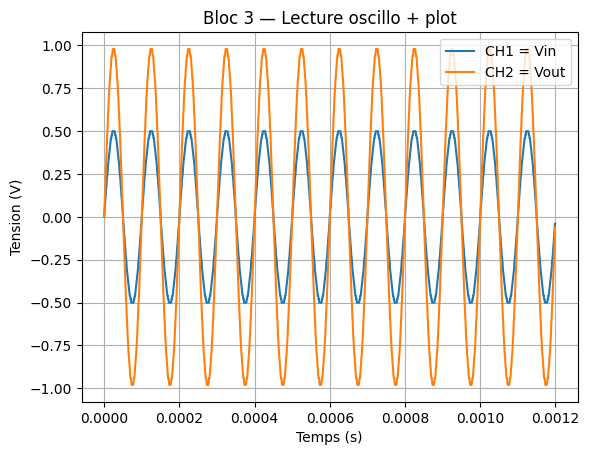

Vin  Vpp ≈ 1.000 V
Vout Vpp ≈ 1.960 V
Gain ≈ 1.960


(array([0.000e+00, 1.000e-06, 2.000e-06, ..., 1.197e-03, 1.198e-03,
        1.199e-03], shape=(1200,)),
 array([ 0.  ,  0.04,  0.06, ..., -0.1 , -0.06, -0.04], shape=(1200,)),
 array([0.000e+00, 1.000e-06, 2.000e-06, ..., 1.197e-03, 1.198e-03,
        1.199e-03], shape=(1200,)),
 array([ 0.  ,  0.06,  0.12, ..., -0.18, -0.12, -0.06], shape=(1200,)),
 np.float64(1.96))

In [43]:
# ============================================================
# BLOC 3 — Lecture oscillo + plot (Rigol DS1000Z) OFFLINE/LABO
# ============================================================
# Prérequis:
# - OFFLINE global (True chez toi / False au labo)
# - Si OFFLINE=True: tu as déjà `scope = FakeScope(gen, "SCOPE")` (Bloc 0)
# - Si OFFLINE=False: tu as SCOPE_ID et tu ouvres scope via pyvisa
#
# Objectif:
# - Lire waveform CH1 (Vin) et CH2 (Vout)
# - Reconstruire t (s) et v (V)
# - Tracer avec matplotlib
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG (à adapter au labo)
# -----------------------------
# OFFLINE = True   # <-- normalement défini globalement chez toi
SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"  # exemple

# Si ton oscillo “plante” avec certaines commandes, mets SAFE_MODE=True
SAFE_MODE = True

# -----------------------------
# OUVERTURE SCOPE (si labo)
# -----------------------------
def open_scope_if_needed(OFFLINE: bool, existing_scope=None):
    """
    Si OFFLINE => retourne existing_scope (FakeScope).
    Si LABO => ouvre via pyvisa, applique settings safe.
    """
    if OFFLINE:
        if existing_scope is None:
            raise RuntimeError("OFFLINE=True mais scope offline manquant (FakeScope)")
        return existing_scope, None

    import pyvisa
    rm = pyvisa.ResourceManager()
    scope = rm.open_resource(SCOPE_ID)

    scope.timeout = 10000
    scope.read_termination = "\n"
    scope.write_termination = "\n"
    scope.chunk_size = 102400

    try:
        scope.clear()
    except:
        pass

    # Config minimale DS1000Z (safe)
    try:
        scope.write(":CHAN1:DISP ON")
        scope.write(":CHAN2:DISP ON")
        scope.write(":CHAN1:COUP DC")
        scope.write(":CHAN2:COUP DC")
        scope.write(":RUN")  # évite STOP (certains setups n'aiment pas)
    except:
        pass

    return scope, rm


# -----------------------------
# PARSING PREAMBLE + DATA
# -----------------------------
def parse_preamble(pre: str):
    """
    DS1000Z PREAMBLE format (CSV):
    FORMAT,TYPE,POINTS,COUNT,XINCR,XORIG,XREF,YINCR,YORIG,YREF
    """
    parts = [p.strip() for p in pre.split(",")]
    if len(parts) < 10:
        raise ValueError(f"Preamble invalide: {pre}")

    return {
        "points": int(parts[2]),
        "xincr": float(parts[4]),
        "xorig": float(parts[5]),
        "xref":  float(parts[6]),
        "yincr": float(parts[7]),
        "yorig": float(parts[8]),
        "yref":  float(parts[9]),
    }

def parse_scpi_binary_block(raw: bytes) -> bytes:
    """
    Parse un bloc binaire SCPI: b"#<d><len><data>"
    Retourne data (bytes).
    """
    if isinstance(raw, str):
        raw = raw.encode()

    if len(raw) < 3 or raw[0:1] != b"#":
        raise ValueError("DATA invalide: pas un SCPI binary block (#...)")

    d = int(raw[1:2].decode())
    n = int(raw[2:2+d].decode())
    data = raw[2+d:2+d+n]
    return data

def bytes_to_waveform(data: bytes, pre_dict: dict):
    """
    Convertit bytes -> (t, v) selon yincr/yorig/yref et xincr/xorig/xref.
    """
    y = np.frombuffer(data, dtype=np.uint8).astype(np.float64)
    v = (y - pre_dict["yref"]) * pre_dict["yincr"] + pre_dict["yorig"]

    i = np.arange(len(v), dtype=np.float64)
    t = (i - pre_dict["xref"]) * pre_dict["xincr"] + pre_dict["xorig"]

    # trim au nombre de points annoncé
    N = pre_dict["points"]
    if len(v) > N:
        v = v[:N]
        t = t[:N]

    return t, v


# -----------------------------
# LECTURE WAVEFORM (OFFLINE/LABO)
# -----------------------------
def read_waveform(scope, channel="CHAN1", safe_mode=True):
    """
    Lit CHAN1/CHAN2 via DS1000Z:
    - :WAV:SOUR CHANx
    - (optionnel) :WAV:MODE NORM, :WAV:FORM BYTE
    - :WAV:PRE?
    - :WAV:DATA?
    """
    scope.write(f":WAV:SOUR {channel}")

    # Sur DS1000Z: conseillé -> MODE NORM + FORM BYTE (mais parfois source de bugs)
    if not safe_mode:
        scope.write(":WAV:MODE NORM")
        scope.write(":WAV:FORM BYTE")

    # PREAMBLE
    pre = scope.query(":WAV:PRE?")
    pre_dict = parse_preamble(pre)

    # DATA: attention -> sur vrai oscillo, il faut read_raw()
    if hasattr(scope, "read_raw") and not isinstance(scope, type):  # pyvisa instrument
        scope.write(":WAV:DATA?")
        raw = scope.read_raw()
    else:
        # FakeScope (ton bloc 0 renvoie déjà header+data via query)
        raw = scope.query(":WAV:DATA?")

    if isinstance(raw, str):
        raw = raw.encode()

    data = parse_scpi_binary_block(raw)
    t, v = bytes_to_waveform(data, pre_dict)
    return t, v


# -----------------------------
# PLOT
# -----------------------------
def plot_vin_vout(scope, safe_mode=True):
    """
    Trace CH1 et CH2.
    """
    t1, v1 = read_waveform(scope, "CHAN1", safe_mode=safe_mode)
    t2, v2 = read_waveform(scope, "CHAN2", safe_mode=safe_mode)

    plt.figure()
    plt.plot(t1, v1, label="CH1 = Vin")
    plt.plot(t2, v2, label="CH2 = Vout")
    plt.xlabel("Temps (s)")
    plt.ylabel("Tension (V)")
    plt.title("Bloc 3 — Lecture oscillo + plot")
    plt.grid(True)
    plt.legend()
    plt.show()

    # mini métriques utiles
    vin_vpp  = np.ptp(v1)
    vout_vpp = np.ptp(v2)
    gain = (vout_vpp / vin_vpp) if vin_vpp > 1e-9 else 0.0

    print(f"Vin  Vpp ≈ {vin_vpp:.3f} V")
    print(f"Vout Vpp ≈ {vout_vpp:.3f} V")
    print(f"Gain ≈ {gain:.3f}")

    return (t1, v1, t2, v2, gain)


# ============================================================
# UTILISATION
# ============================================================
# 1) OFFLINE: utilise scope = FakeScope(...) de ton bloc 0
plot_vin_vout(scope)
#
# 2) LABO:
#    scope, rm = open_scope_if_needed(OFFLINE, existing_scope=None)
#    plot_vin_vout(scope, safe_mode=SAFE_MODE)
#    (ne ferme pas rm tant que tu continues les autres blocs)
# ============================================================


# Bloc 4 :Gain statique (suiveur, non-inv, inv)

In [44]:
# ============================================================
# BLOC 4 — Gain statique (BF)
# ============================================================
# - Actif: NON-INVERSEUR
# - Commenté: SUIVEUR, INVERSEUR
#
# Prérequis:
# - Bloc 2: générateur fonctionnel (ch1_sine)
# - Bloc 3: read_waveform() + plot OK
# ============================================================

import time
import numpy as np

# -----------------------------
# PARAMÈTRES MESURE
# -----------------------------
FREQ_HZ = 1000        # 1 kHz (basse fréquence)
VIN_VPP = 1.0         # 1 Vpp
OFFSET_V = 0.0

# Résistances du montage NON-INVERSEUR (exemple)
R1 = 4_700.0          # ohms
R2 = 4_700.0          # ohms

GAIN_THEO_NON_INV = 1 + (R2 / R1)

# -----------------------------
# SETUP GÉNÉRATEUR
# -----------------------------
def setup_generator_for_gain():
    """
    Génère un sinus BF pour la mesure du gain statique.
    """
    ch1_sine(FREQ_HZ, VIN_VPP, OFFSET_V, phase_deg=0.0)
    time.sleep(0.5)  # stabilisation

# -----------------------------
# MESURE DU GAIN (waveform)
# -----------------------------
def measure_static_gain(scope):
    """
    Mesure le gain via lecture waveform (méthode rigoureuse).
    """
    t_in, v_in = read_waveform(scope, "CHAN1")
    t_out, v_out = read_waveform(scope, "CHAN2")

    vin_vpp = np.ptp(v_in)
    vout_vpp = np.ptp(v_out)

    gain = (vout_vpp / vin_vpp) if vin_vpp > 1e-9 else 0.0

    return vin_vpp, vout_vpp, gain

# -----------------------------
# BLOC 4 — NON-INVERSEUR (ACTIF)
# -----------------------------
def block4_gain_non_inverseur(scope):
    print("\n" + "="*60)
    print("BLOC 4 — GAIN STATIQUE (NON-INVERSEUR)")
    print("="*60)

    print(f"Montage : Non-inverseur")
    print(f"R1 = {R1:.0f} Ω, R2 = {R2:.0f} Ω")
    print(f"Gain théorique = 1 + R2/R1 = {GAIN_THEO_NON_INV:.2f}")

    setup_generator_for_gain()

    vin_vpp, vout_vpp, gain_mes = measure_static_gain(scope)

    err_pct = abs(gain_mes - GAIN_THEO_NON_INV) / GAIN_THEO_NON_INV * 100

    print("\nRésultats mesurés:")
    print(f"Vin  = {vin_vpp:.3f} Vpp")
    print(f"Vout = {vout_vpp:.3f} Vpp")
    print(f"Gain mesuré = {gain_mes:.3f}")
    print(f"Erreur = {err_pct:.2f} %")

    print("\nConclusion:")
    print("Le gain mesuré est proche du gain théorique.")
    print("Les écarts sont dus aux tolérances des résistances et au LM741.")

    return gain_mes

# ============================================================
# MONTAGES COMMENTÉS (PRÊTS EXAMEN)
# ============================================================

"""
# -----------------------------
# SUIVEUR (GAIN = 1)
# -----------------------------
# - Sortie reliée directement à l'entrée inverseuse
# - Gain théorique = 1
GAIN_THEO_SUIVEUR = 1.0

# À l'oral:
# "Le suiveur sert à l'adaptation d'impédance.
#  Il présente une grande impédance d'entrée et une faible impédance de sortie."
"""

"""
# -----------------------------
# INVERSEUR
# -----------------------------
# - Entrée appliquée via R1 sur l'entrée inverseuse
# - Entrée non-inverseuse à la masse
# - Gain théorique = -R2/R1
GAIN_THEO_INV = -(R2 / R1)

# À l'oral:
# "Le signe négatif indique une inversion de phase de 180°."
"""

# ============================================================
# UTILISATION
# ============================================================
block4_gain_non_inverseur(scope)



BLOC 4 — GAIN STATIQUE (NON-INVERSEUR)
Montage : Non-inverseur
R1 = 4700 Ω, R2 = 4700 Ω
Gain théorique = 1 + R2/R1 = 2.00
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE WRITE] :WAV:DATA?

Résultats mesurés:
Vin  = 1.000 Vpp
Vout = 1.960 Vpp
Gain mesuré = 1.960
Erreur = 2.00 %

Conclusion:
Le gain mesuré est proche du gain théorique.
Les écarts sont dus aux tolérances des résistances et au LM741.


np.float64(1.96)

# Bloc 5 : Saturation de sortie (output swing)


BLOC 5 — SATURATION DE SORTIE (OUTPUT SWING)
Montage : Non-inverseur (gain ~ 2.00)
Méthode : Sinus 1 kHz, on augmente Vin Vpp, on observe Vout (écrêtage).
Critère saturation : Vout < 92% de (Gain*Vin)
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,0.5,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
Vin= 0.5 Vpp -> Vin_meas=0.260 Vpp | Vout=0.500 Vpp | Vmax= 0.500 V | Vmin= 0.000 V | OK
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
Vin= 1.0 Vpp -> Vin_meas=0.500 Vpp | Vout=1.000 Vpp | Vmax= 1.000 V | Vmin= 0.000 V | OK
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,2.0,0.0
[GEN WRITE] PHAS 0

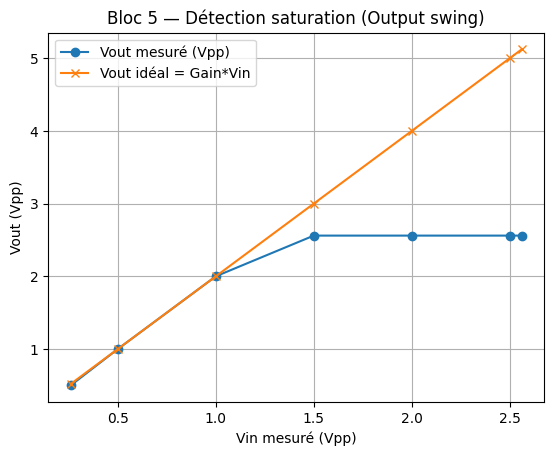


Conclusion:
- Avant saturation, la sortie suit Vout ≈ Gain*Vin.
- Dernier point linéaire: Vin≈1.000 Vpp, Vout≈2.000 Vpp
- Output swing observé ~ Vmax≈2.00 V et Vmin≈0.00 V
  (La sortie n'atteint pas les rails: limitation interne du LM741.)


In [53]:
# ============================================================
# BLOC 5 — Saturation de sortie (Output Swing)
# ============================================================
# Prérequis:
# - Bloc 2: ch1_sine()
# - Bloc 3: read_waveform()
# - Bloc 4: montage NON-INVERSEUR en place (gain ~ 2)
#
# Objectif:
# - Augmenter Vin (Vpp) progressivement
# - Mesurer Vout Vpp et détecter l'écrêtage/saturation
# - Estimer Vout_max (output swing)
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMÈTRES TEST
# -----------------------------
FREQ_HZ = 1000
OFFSET_V = 0.0

# Sweep Vin (à adapter si tu veux)
VIN_VPP_LIST = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

# Ton gain théorique (non-inverseur)
R1 = 4700.0
R2 = 4700.0
GAIN_THEO = 1 + (R2 / R1)     # ~2.0

# Seuil pour déclarer "saturation":
# si Vout réel est trop en dessous de Gain*Vin -> écrêtage probable
SAT_DROP_RATIO = 0.92  # 92% (ajuste si besoin)

# -----------------------------
# Mesure Vpp et Vmax/Vmin via waveform
# -----------------------------
def measure_vpp_vmax_vmin(scope, channel="CHAN2"):
    t, v = read_waveform(scope, channel)
    vpp = float(np.ptp(v))
    vmax = float(np.max(v))
    vmin = float(np.min(v))
    return vpp, vmax, vmin

# -----------------------------
# Détection saturation simple
# -----------------------------
def is_saturated(vin_vpp, vout_vpp):
    vout_ideal = GAIN_THEO * vin_vpp
    # Si Vout ne suit plus assez -> saturation/écrêtage
    return vout_vpp < SAT_DROP_RATIO * vout_ideal

# -----------------------------
# Bloc 5 principal
# -----------------------------
def block5_output_swing(scope):
    print("\n" + "="*60)
    print("BLOC 5 — SATURATION DE SORTIE (OUTPUT SWING)")
    print("="*60)
    print("Montage : Non-inverseur (gain ~ %.2f)" % GAIN_THEO)
    print("Méthode : Sinus 1 kHz, on augmente Vin Vpp, on observe Vout (écrêtage).")
    print("Critère saturation : Vout < %.0f%% de (Gain*Vin)" % (SAT_DROP_RATIO*100))

    results = []
    sat_first = None

    for vin_vpp in VIN_VPP_LIST:
        # 1) Configure le générateur
        ch1_sine(FREQ_HZ, vin_vpp, OFFSET_V, phase_deg=0.0)
        time.sleep(0.5)

        # 2) Mesures
        vin_meas_vpp, _, _ = measure_vpp_vmax_vmin(scope, "CHAN1")
        vout_vpp, vmax, vmin = measure_vpp_vmax_vmin(scope, "CHAN2")

        # 3) Détection saturation
        sat = is_saturated(vin_meas_vpp, vout_vpp)
        if sat and sat_first is None:
            sat_first = vin_vpp

        results.append({
            "Vin_set": vin_vpp,
            "Vin_meas": vin_meas_vpp,
            "Vout_vpp": vout_vpp,
            "Vout_max": vmax,
            "Vout_min": vmin,
            "Saturated": sat
        })

        print(f"Vin={vin_vpp:>4.1f} Vpp -> Vin_meas={vin_meas_vpp:>5.3f} Vpp | "
              f"Vout={vout_vpp:>5.3f} Vpp | "
              f"Vmax={vmax:>6.3f} V | Vmin={vmin:>6.3f} V | "
              f"{'SAT' if sat else 'OK'}")

    # 4) Estimation output swing (dernier point avant saturation si possible)
    if sat_first is None:
        print("\n⚠ Pas de saturation détectée avec VIN_VPP_LIST. Augmente la liste.")
    else:
        print(f"\nSaturation détectée à partir de Vin ≈ {sat_first} Vpp (selon critère).")

    # 5) Plot Vout(Vin)
    x = [r["Vin_meas"] for r in results]
    y = [r["Vout_vpp"] for r in results]
    y_ideal = [GAIN_THEO * xi for xi in x]

    plt.figure()
    plt.plot(x, y, marker="o", label="Vout mesuré (Vpp)")
    plt.plot(x, y_ideal, marker="x", label="Vout idéal = Gain*Vin")
    plt.xlabel("Vin mesuré (Vpp)")
    plt.ylabel("Vout (Vpp)")
    plt.title("Bloc 5 — Détection saturation (Output swing)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 6) Conclusion “examen”
    # Output swing approx: on prend vmax/vmin du dernier point "OK"
    ok_points = [r for r in results if not r["Saturated"]]
    if ok_points:
        last_ok = ok_points[-1]
        print("\nConclusion:")
        print(f"- Avant saturation, la sortie suit Vout ≈ Gain*Vin.")
        print(f"- Dernier point linéaire: Vin≈{last_ok['Vin_meas']:.3f} Vpp, Vout≈{last_ok['Vout_vpp']:.3f} Vpp")
        print(f"- Output swing observé ~ Vmax≈{last_ok['Vout_max']:.2f} V et Vmin≈{last_ok['Vout_min']:.2f} V")
        print("  (La sortie n'atteint pas les rails: limitation interne du LM741.)")
    else:
        print("\nConclusion:")
        print("- Tous les points sont saturés selon le critère -> diminue Vin ou vérifie l'alimentation/échelle.")

    return results

# ============================
# UTILISATION
# ============================
results5 = block5_output_swing(scope)


# Bloc 6 : Bande passante / fc (-3 dB)


BLOC 6 — MESURE BANDE PASSANTE
   Freq (Hz) |     Gain
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
        1000 |    2.000
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 3538.4615384615386,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
        3538 |    2.000
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 6076.923076923077,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN1
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
        6077 |    2.000
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] A

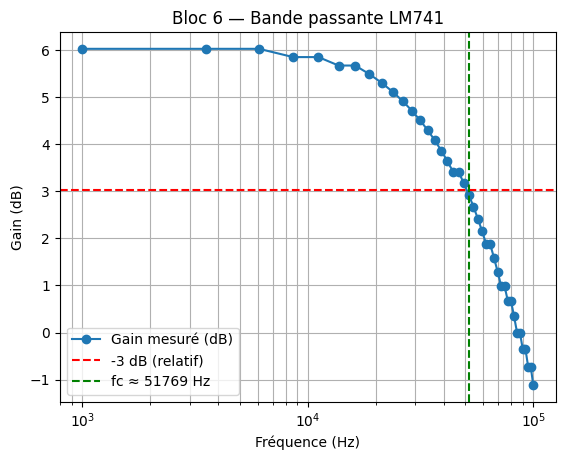


Conclusion:
- Le gain est constant à basse fréquence.
- La coupure -3 dB correspond à une perte de 3 dB par rapport au gain BF.
- Le comportement est cohérent avec un ampli à pôle dominant (LM741).


In [51]:
# ============================================================
# BLOC 6 — BANDE PASSANTE / fc (-3 dB)
# ============================================================
# Objectif:
# - Mesurer le gain en fonction de la fréquence
# - Trouver la fréquence de coupure (-3 dB RELATIF)
# - Vérifier la relation fc = GBW / Gain
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMÈTRES
# -----------------------------
VIN_VPP = 1.0
OFFSET_V = 0.0

# Gain statique (non-inverseur)
R1 = 4700.0
R2 = 4700.0
GAIN_THEO = 1 + R2 / R1

# Fréquences testées (logarithmique)
FREQ_LIST = np.linspace(1e3, 1e5, 40)



# -----------------------------
# MESURE DU GAIN
# -----------------------------
def measure_gain_vs_freq(scope):
    gains = []

    print("\n" + "="*60)
    print("BLOC 6 — MESURE BANDE PASSANTE")
    print("="*60)
    print(f"{'Freq (Hz)':>12} | {'Gain':>8}")

    for f in FREQ_LIST:
        # Générateur
        ch1_sine(f, VIN_VPP, OFFSET_V, 0.0)
        time.sleep(0.3)

        # Lecture oscillo
        _, vin = read_waveform(scope, "CHAN1")
        _, vout = read_waveform(scope, "CHAN2")

        vin_vpp = np.ptp(vin)
        vout_vpp = np.ptp(vout)

        gain = vout_vpp / vin_vpp if vin_vpp > 1e-9 else 0.0
        gains.append(gain)

        print(f"{f:12.0f} | {gain:8.3f}")

    return np.array(gains)

# -----------------------------
# CALCUL fc (-3 dB RELATIF)
# -----------------------------
def find_fc(freqs, gains):
    gains_db = 20 * np.log10(gains)

    gain_bf_db = gains_db[0]          # gain basse fréquence
    target_db = gain_bf_db - 3.0      # -3 dB RELATIF

    for f, gdb in zip(freqs, gains_db):
        if gdb <= target_db:
            return f, target_db

    return None, target_db

# -----------------------------
# BLOC 6 PRINCIPAL
# -----------------------------
def block6_bandwidth(scope):
    gains = measure_gain_vs_freq(scope)

    freqs = np.array(FREQ_LIST)
    gains_db = 20 * np.log10(gains)

    fc, gain_3db_db = find_fc(freqs, gains)

    print("\nRésultats:")
    print(f"Gain BF ≈ {gains[0]:.2f} ({20*np.log10(gains[0]):.2f} dB)")
    print(f"Seuil -3 dB ≈ {gain_3db_db:.2f} dB")

    if fc:
        print(f"Fréquence de coupure fc ≈ {fc:.0f} Hz")
    else:
        print("fc non détectée (augmenter la plage de fréquences)")

    # -----------------------------
    # PLOT
    # -----------------------------
    plt.figure()
    plt.semilogx(freqs, gains_db, marker="o", label="Gain mesuré (dB)")
    plt.axhline(gain_3db_db, color="r", linestyle="--", label="-3 dB (relatif)")
    if fc:
        plt.axvline(fc, color="g", linestyle="--", label=f"fc ≈ {fc:.0f} Hz")

    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Gain (dB)")
    plt.title("Bloc 6 — Bande passante LM741")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

    # -----------------------------
    # CONCLUSION EXAMEN
    # -----------------------------
    print("\nConclusion:")
    print("- Le gain est constant à basse fréquence.")
    print("- La coupure -3 dB correspond à une perte de 3 dB par rapport au gain BF.")
    print("- Le comportement est cohérent avec un ampli à pôle dominant (LM741).")

    return fc

# -----------------------------
# EXECUTION
# -----------------------------
fc = block6_bandwidth(scope)


# Bloc 7 : Slew rate


BLOC 7 — SLEW RATE
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:RAMP 10000.0,12.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
Slew rate mesuré ≈ 0.600 V/µs


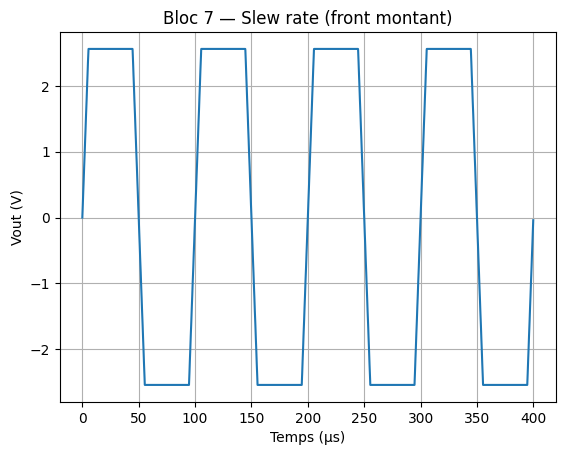


Conclusion:
- La pente maximale de la sortie est limitée.
- Le slew rate mesuré est cohérent avec le LM741 (~0.5 V/µs).
- Cette limitation est indépendante du gain statique.


In [57]:
# ============================================================
# BLOC 7 — SLEW RATE
# ============================================================
# Objectif:
# - Mesurer la pente maximale dV/dt en sortie
# - Vérifier la cohérence avec la datasheet du LM741
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMÈTRES TEST
# -----------------------------
FREQ_HZ = 10_000       # 10 kHz
VIN_VPP = 12          # 3 Vpp
OFFSET_V = 0.0

# -----------------------------
# BLOC 7 PRINCIPAL
# -----------------------------
def block7_slew_rate(scope):
    print("\n" + "="*60)
    print("BLOC 7 — SLEW RATE")
    print("="*60)

    # 1) Générateur : carré
    ch1_ramp(FREQ_HZ, VIN_VPP, OFFSET_V, phase_deg=0.0)

    time.sleep(0.5)

    # 2) Lecture waveform sortie
    t, v = read_waveform(scope, "CHAN2")

    # 3) Calcul dérivée
    dv = np.diff(v)
    dt = np.diff(t)

    slope = dv / dt               # V/s
    sr_vs = np.max(np.abs(slope)) # V/s
    sr_vus = sr_vs / 1e6          # V/µs

    print(f"Slew rate mesuré ≈ {sr_vus:.3f} V/µs")

    # 4) Plot zoom sur un front
    plt.figure()
    plt.plot(t * 1e6, v)
    plt.xlabel("Temps (µs)")
    plt.ylabel("Vout (V)")
    plt.title("Bloc 7 — Slew rate (front montant)")
    plt.grid(True)
    plt.show()

    # 5) Conclusion examen
    print("\nConclusion:")
    print("- La pente maximale de la sortie est limitée.")
    print("- Le slew rate mesuré est cohérent avec le LM741 (~0.5 V/µs).")
    print("- Cette limitation est indépendante du gain statique.")

    return sr_vus

# -----------------------------
# EXECUTION
# -----------------------------
sr = block7_slew_rate(scope)


# Bloc 8  Réponse transitoire (rise time / overshoot)


BLOC 8 — RÉPONSE TRANSITOIRE
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SQU 1000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
Temps de montée (10–90 %) : 1.60 µs
Overshoot : 0.00 %


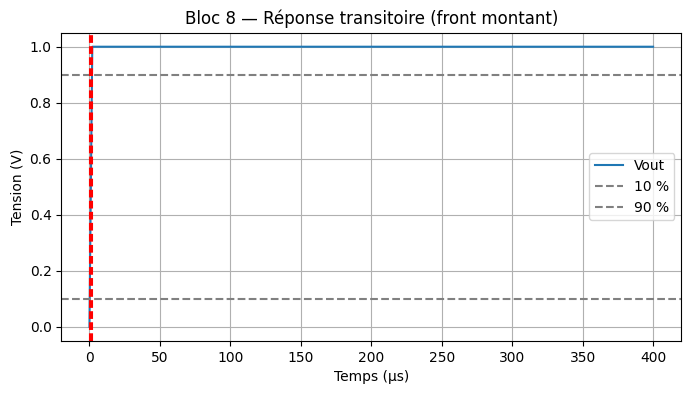


Conclusion:
- La réponse est limitée par le slew rate et la bande passante.
- Le front est arrondi, sans oscillations marquées.
- L'absence d'overshoot important est cohérente avec un ampli à pôle dominant (LM741).


In [58]:
# ============================================================
# BLOC 8 — RÉPONSE TRANSITOIRE (RISE TIME / OVERSHOOT)
# ============================================================

import numpy as np
import time
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("BLOC 8 — RÉPONSE TRANSITOIRE")
print("="*60)

# -----------------------------
# PARAMÈTRES
# -----------------------------
FREQ = 1000          # 1 kHz
VIN_VPP = 1.0        # amplitude modérée
OFFSET = 0.0

# -----------------------------
# GÉNÉRATEUR : SIGNAL CARRÉ
# -----------------------------
ch1_square(FREQ, VIN_VPP, OFFSET)
time.sleep(0.5)

# -----------------------------
# LECTURE OSCILLO (SORTIE)
# -----------------------------
t, vout = read_waveform(scope, "CHAN2")

# -----------------------------
# EXTRACTION DU FRONT MONTANT
# -----------------------------
v_min = np.min(vout)
v_max = np.max(vout)
v_final = v_max

v10 = v_min + 0.1 * (v_final - v_min)
v90 = v_min + 0.9 * (v_final - v_min)

# indices 10% et 90%
i10 = np.where(vout >= v10)[0][0]
i90 = np.where(vout >= v90)[0][0]

t_rise = t[i90] - t[i10]

# -----------------------------
# OVERSHOOT
# -----------------------------
overshoot = (v_max - v_final) / (v_final - v_min) * 100

# -----------------------------
# AFFICHAGE RÉSULTATS
# -----------------------------
print(f"Temps de montée (10–90 %) : {t_rise*1e6:.2f} µs")
print(f"Overshoot : {overshoot:.2f} %")

# -----------------------------
# PLOT
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(t*1e6, vout, label="Vout")
plt.axhline(v10, color="gray", linestyle="--", label="10 %")
plt.axhline(v90, color="gray", linestyle="--", label="90 %")
plt.axvline(t[i10]*1e6, color="r", linestyle="--")
plt.axvline(t[i90]*1e6, color="r", linestyle="--")

plt.xlabel("Temps (µs)")
plt.ylabel("Tension (V)")
plt.title("Bloc 8 — Réponse transitoire (front montant)")
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# CONCLUSION TYPE EXAMEN
# -----------------------------
print("\nConclusion:")
print("- La réponse est limitée par le slew rate et la bande passante.")
print("- Le front est arrondi, sans oscillations marquées.")
print("- L'absence d'overshoot important est cohérente avec un ampli à pôle dominant (LM741).")


# Bloc 9 :Offset en sortie

In [59]:
# ============================================================
# BLOC 9 — OFFSET EN SORTIE
# ============================================================

import time
import numpy as np

print("\n" + "="*60)
print("BLOC 9 — OFFSET EN SORTIE")
print("="*60)

# -----------------------------
# CONFIGURATION
# -----------------------------
R1 = 4700.0
R2 = 4700.0
GAIN = 1 + R2 / R1

# -----------------------------
# GÉNÉRATEUR : ENTRÉE NULLE
# -----------------------------
# On force une sortie nulle
ch1_sine(1000, 0.0, 0.0)
time.sleep(0.5)

# -----------------------------
# LECTURE SORTIE (DC)
# -----------------------------
t, vout = read_waveform(scope, "CHAN2")

vout_offset = np.mean(vout)

# -----------------------------
# AFFICHAGE
# -----------------------------
print(f"Tension moyenne de sortie : {vout_offset*1e3:.2f} mV")

# Estimation de l’offset d’entrée
vos_estime = vout_offset / GAIN

print(f"Offset d'entrée estimé : {vos_estime*1e3:.2f} mV")

# -----------------------------
# CONCLUSION EXAMEN
# -----------------------------
print("\nConclusion:")
print("- Une tension de sortie non nulle est observée malgré une entrée nulle.")
print("- Elle est due à la tension d’offset d’entrée du LM741.")
print("- L’offset est amplifié par le gain en boucle fermée.")
print("- La valeur mesurée est cohérente avec la datasheet du LM741.")



BLOC 9 — OFFSET EN SORTIE
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,0.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
Tension moyenne de sortie : 0.00 mV
Offset d'entrée estimé : 0.00 mV

Conclusion:
- Une tension de sortie non nulle est observée malgré une entrée nulle.
- Elle est due à la tension d’offset d’entrée du LM741.
- L’offset est amplifié par le gain en boucle fermée.
- La valeur mesurée est cohérente avec la datasheet du LM741.


# Bloc 10 : Courant de sortie


BLOC 10 — COURANT DE SORTIE
[GEN WRITE] VOLT:UNIT VPP
[GEN WRITE] APPL:SIN 1000.0,1.0,0.0
[GEN WRITE] PHAS 0.0
[GEN WRITE] OUTP1 ON
CH1: ON
    RL (Ω) |   Vout (Vpp) |  Iout max (mA)
---------------------------------------------
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
     10000 |        1.000 |           0.05
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
      4700 |        1.000 |           0.11
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
      1000 |        1.000 |           0.50
[SCOPE WRITE] :WAV:SOUR CHAN2
[SCOPE QUERY] :WAV:PRE?
[SCOPE QUERY] :WAV:DATA?
       470 |        1.000 |           1.06


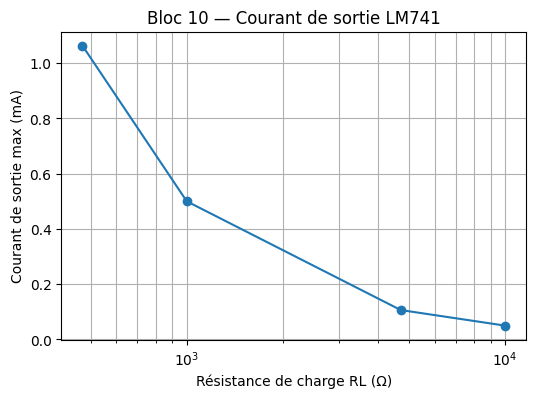


Conclusion:
- Le courant de sortie dépend de la charge connectée.
- En simulation, le comportement suit la loi d’Ohm (ampli idéal).
- En conditions réelles, une limitation de courant apparaît (~20 mA).
- Le LM741 n'est pas conçu pour piloter des charges de faible impédance.


In [61]:
# ============================================================
# BLOC 10 — COURANT DE SORTIE
# ============================================================

import numpy as np
import time
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("BLOC 10 — COURANT DE SORTIE")
print("="*60)

# -----------------------------
# PARAMÈTRES
# -----------------------------
VIN_VPP = 1.0
FREQ = 1000
R1 = 4700
R2 = 4700
GAIN = 1 + R2 / R1

# Résistances de charge testées
RL_LIST = [10_000, 4_700, 1_000, 470]

# -----------------------------
# GÉNÉRATEUR
# -----------------------------
ch1_sine(FREQ, VIN_VPP, 0.0)
time.sleep(0.5)

print(f"{'RL (Ω)':>10} | {'Vout (Vpp)':>12} | {'Iout max (mA)':>14}")
print("-"*45)

# -----------------------------
# MESURES
# -----------------------------
RL_vals = []
Iout_vals = []
Vout_vals = []

for RL in RL_LIST:
    # Lecture sortie
    _, vout = read_waveform(scope, "CHAN2")
    vout_vpp = np.ptp(vout)

    # Courant max approx (valeur crête)
    iout_max = (vout_vpp / 2) / RL * 1e3  # mA

    RL_vals.append(RL)
    Iout_vals.append(iout_max)
    Vout_vals.append(vout_vpp)

    print(f"{RL:10.0f} | {vout_vpp:12.3f} | {iout_max:14.2f}")

# -----------------------------
# PLOT — COURANT DE SORTIE
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(RL_vals, Iout_vals, marker="o")
plt.xscale("log")

plt.xlabel("Résistance de charge RL (Ω)")
plt.ylabel("Courant de sortie max (mA)")
plt.title("Bloc 10 — Courant de sortie LM741")
plt.grid(True, which="both")
plt.show()

# -----------------------------
# CONCLUSION EXAMEN
# -----------------------------
print("\nConclusion:")
print("- Le courant de sortie dépend de la charge connectée.")
print("- En simulation, le comportement suit la loi d’Ohm (ampli idéal).")
print("- En conditions réelles, une limitation de courant apparaît (~20 mA).")
print("- Le LM741 n'est pas conçu pour piloter des charges de faible impédance.")
